In [6]:
import sys
import pdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm

plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil

### Step 1
Either read or compute the impact, pvalues, and coherence

/tmp/ipykernel_387526/1504185868.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(16,4))


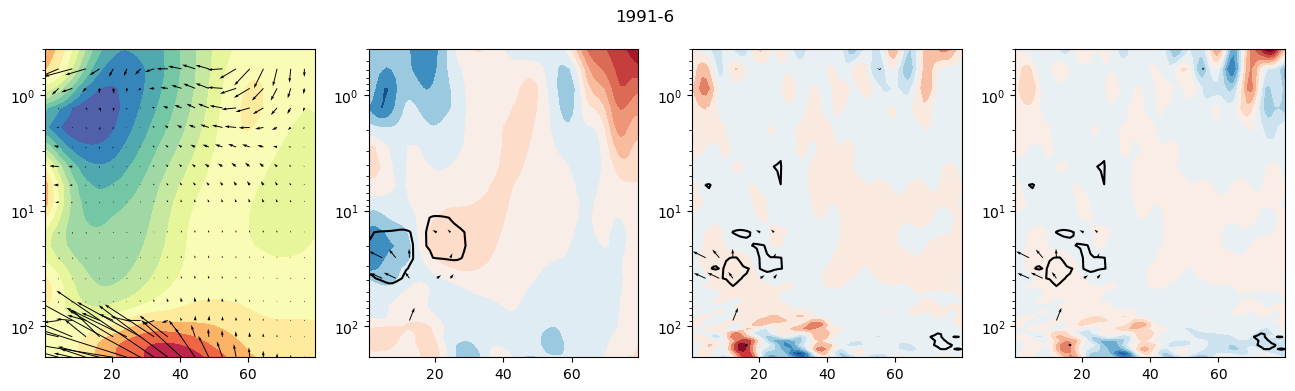

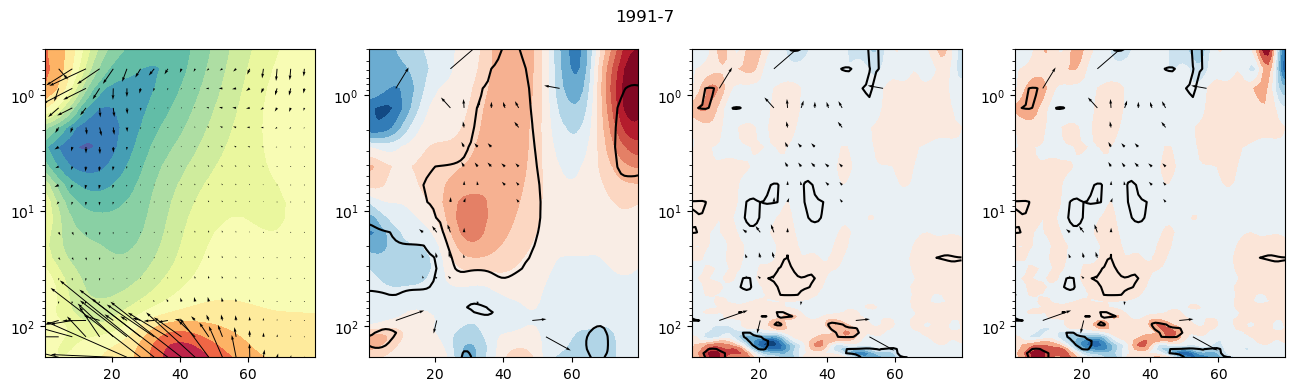

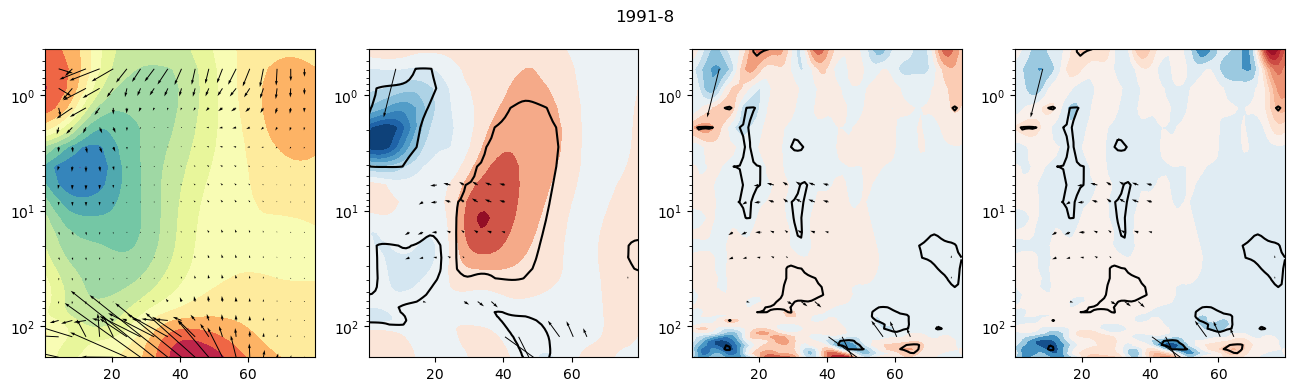

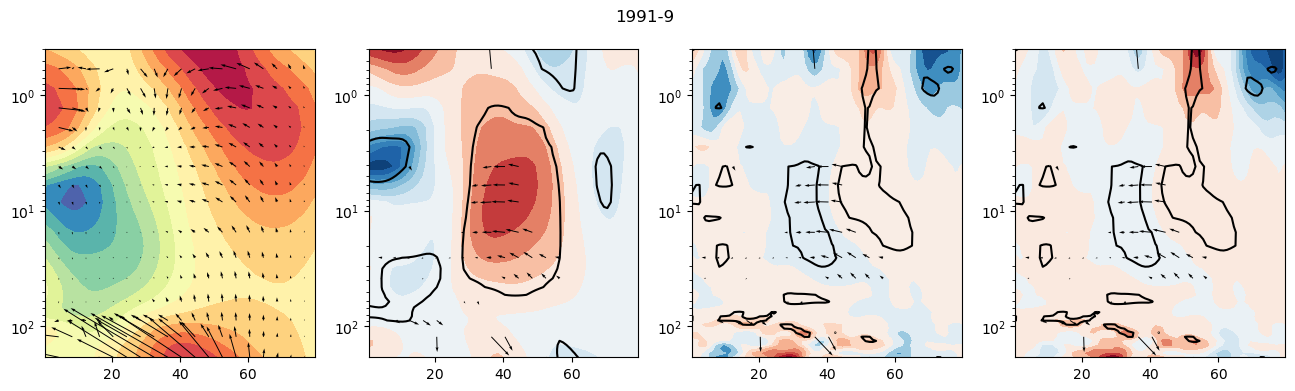

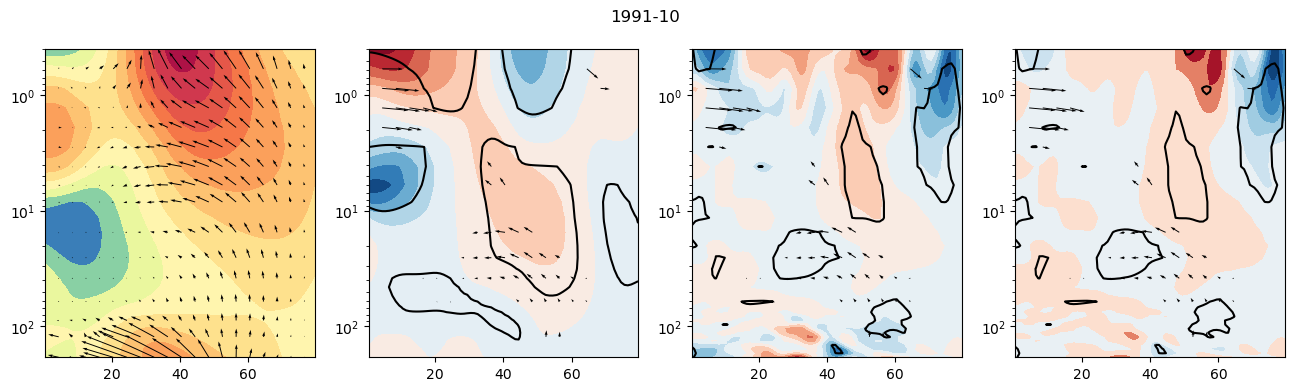

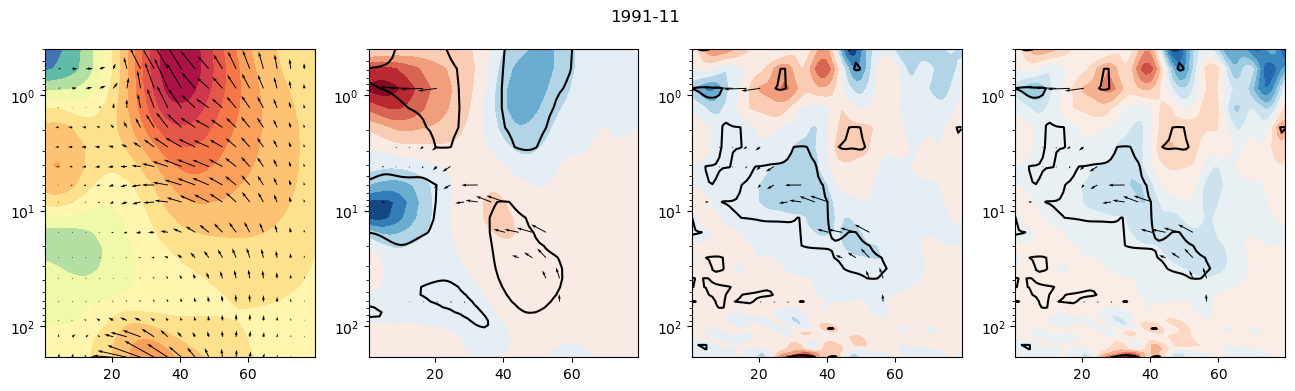

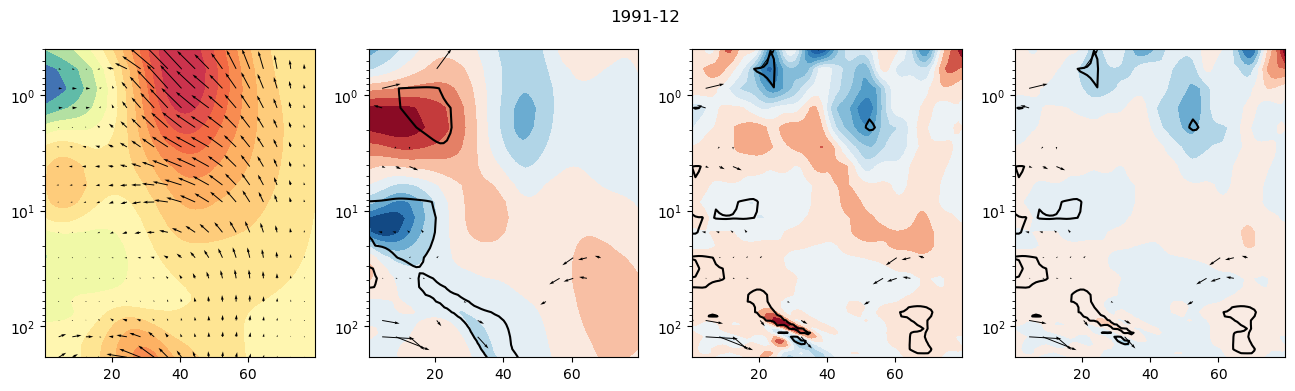

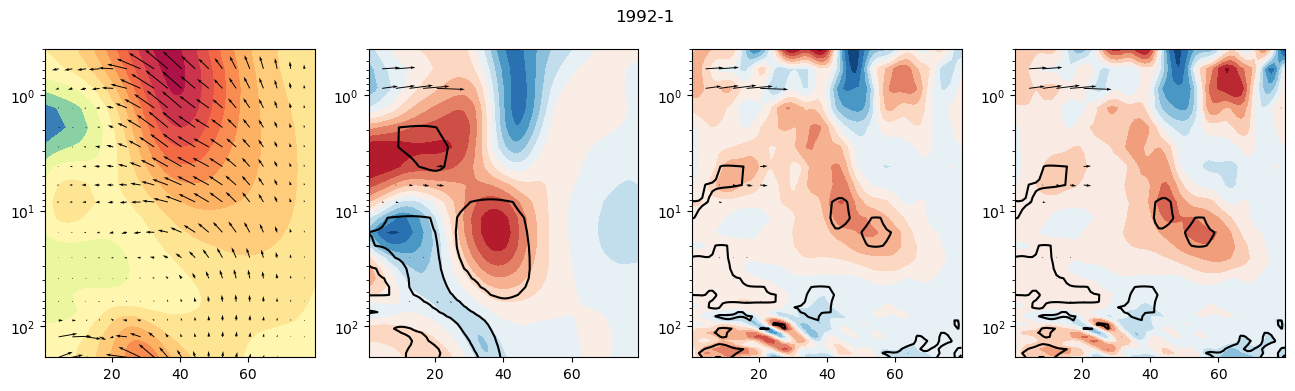

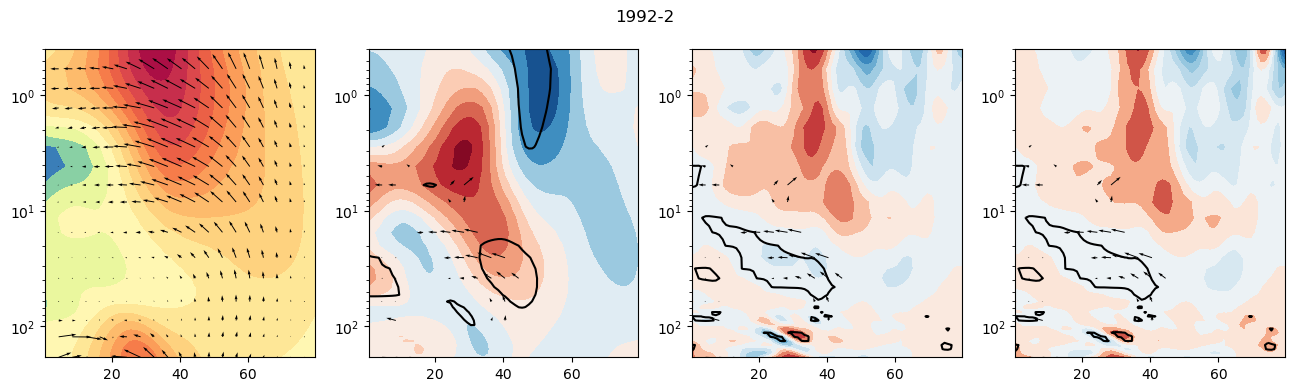

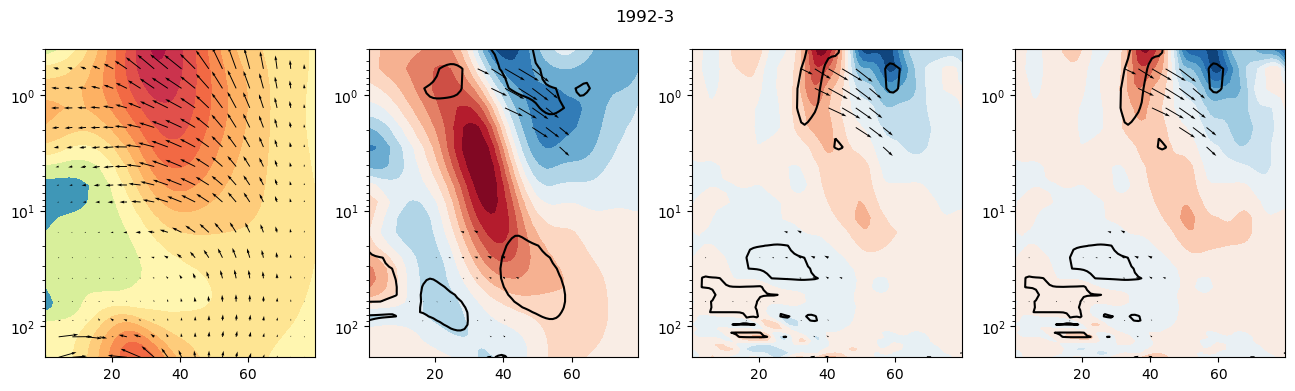

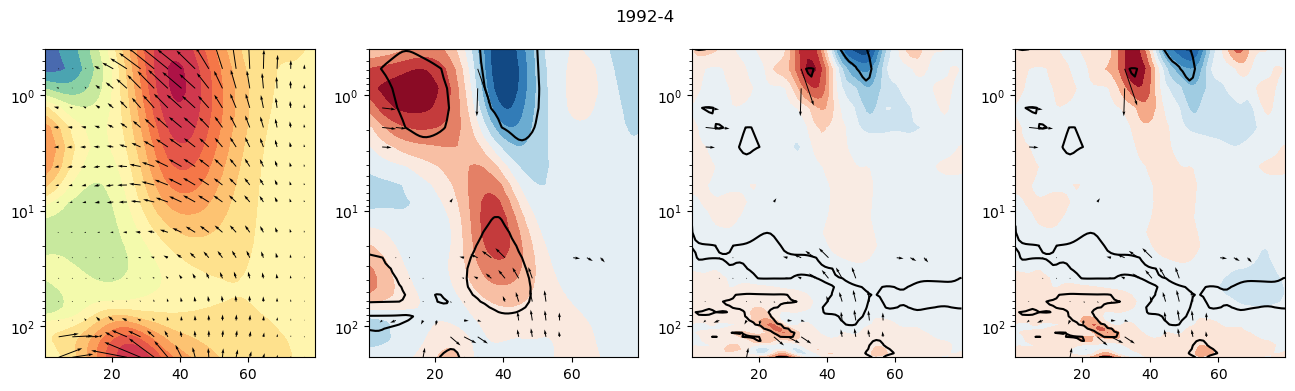

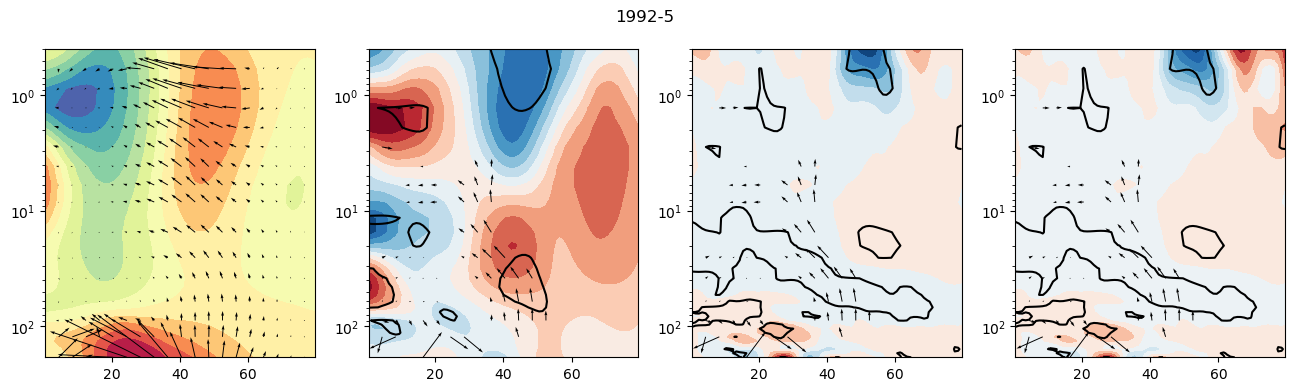

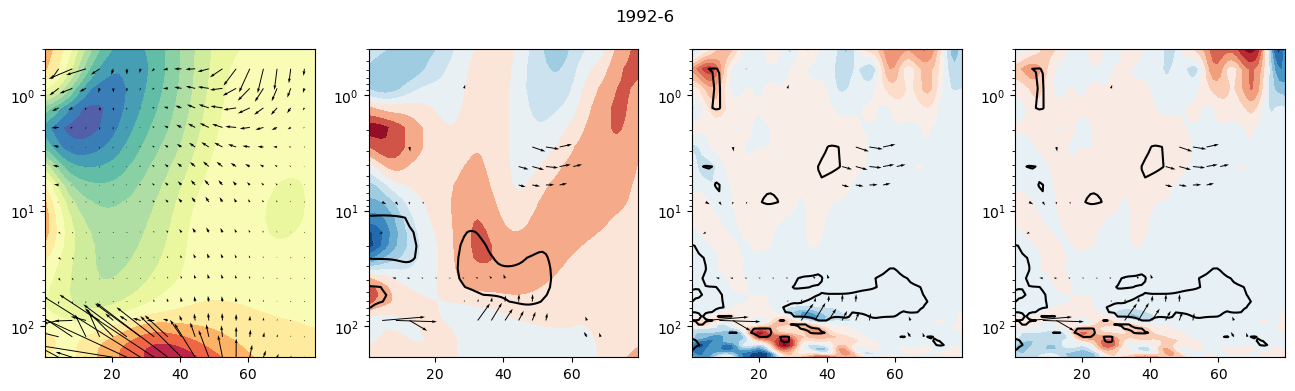

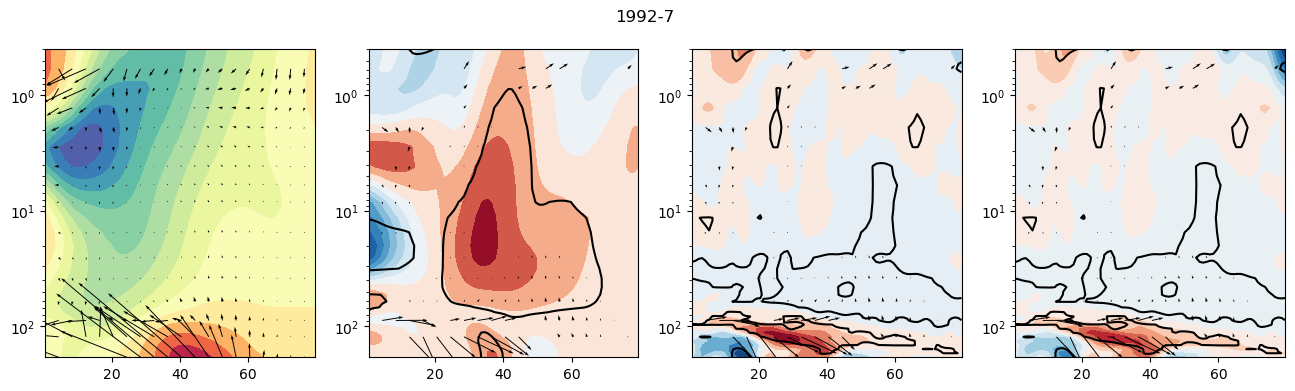

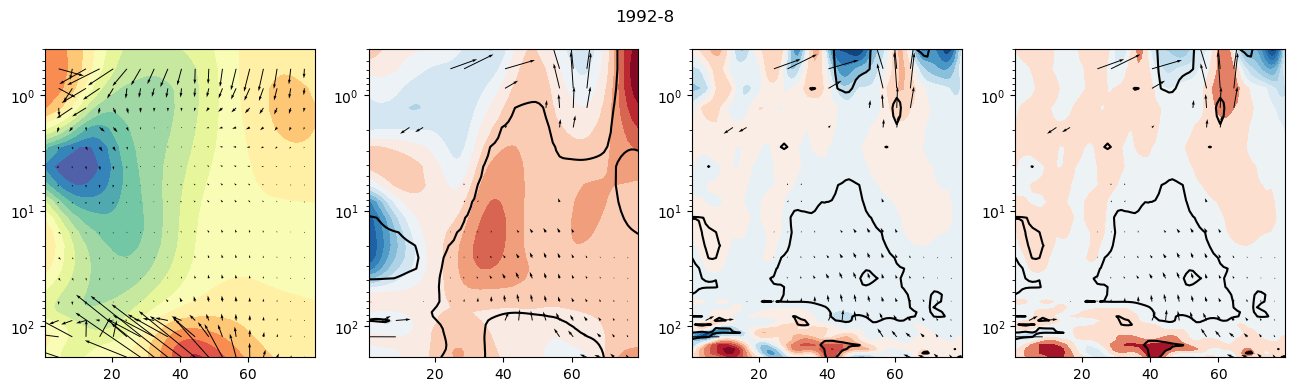

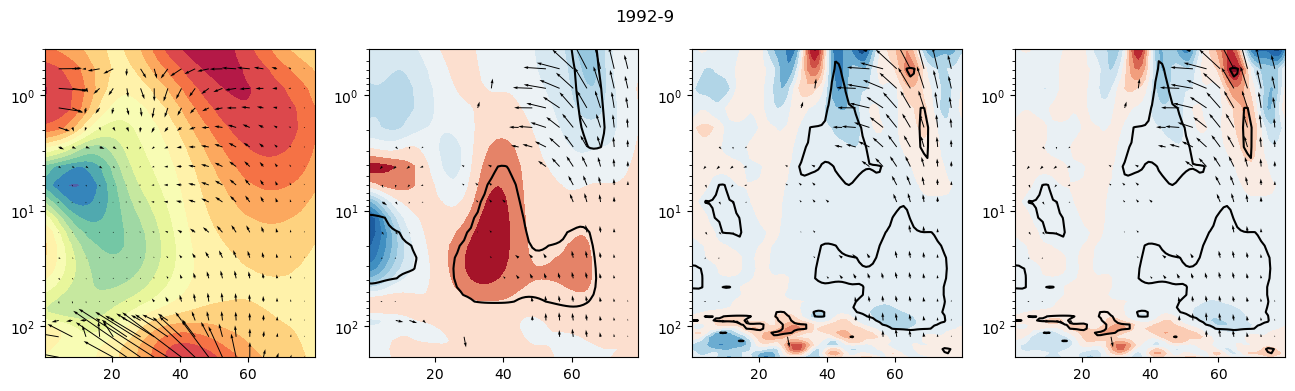

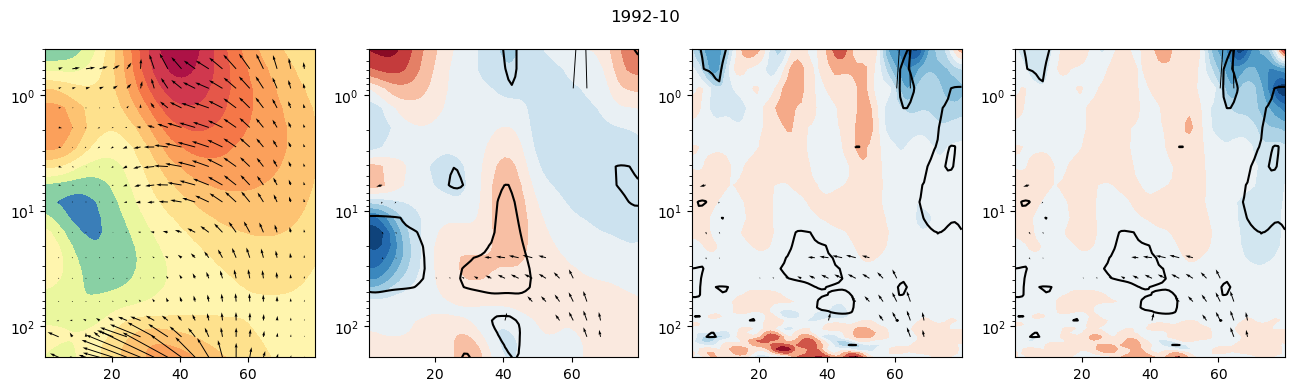

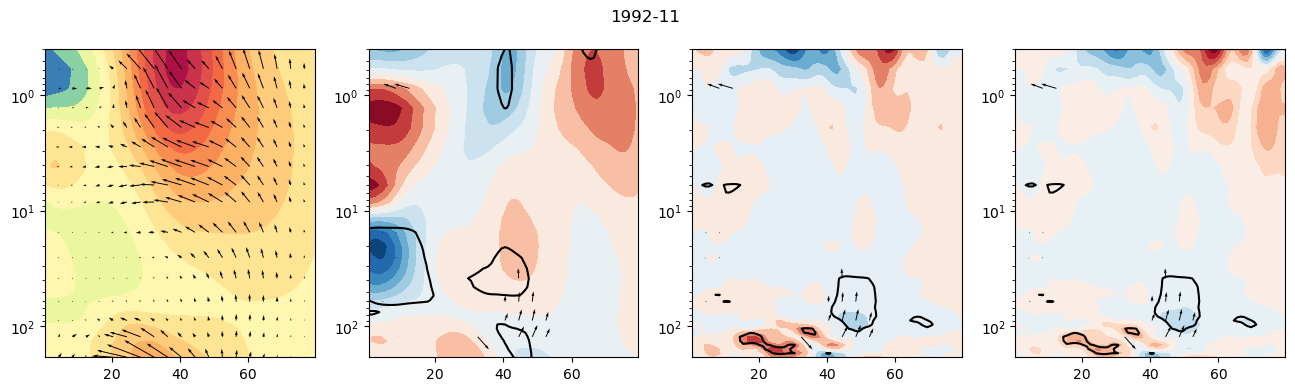

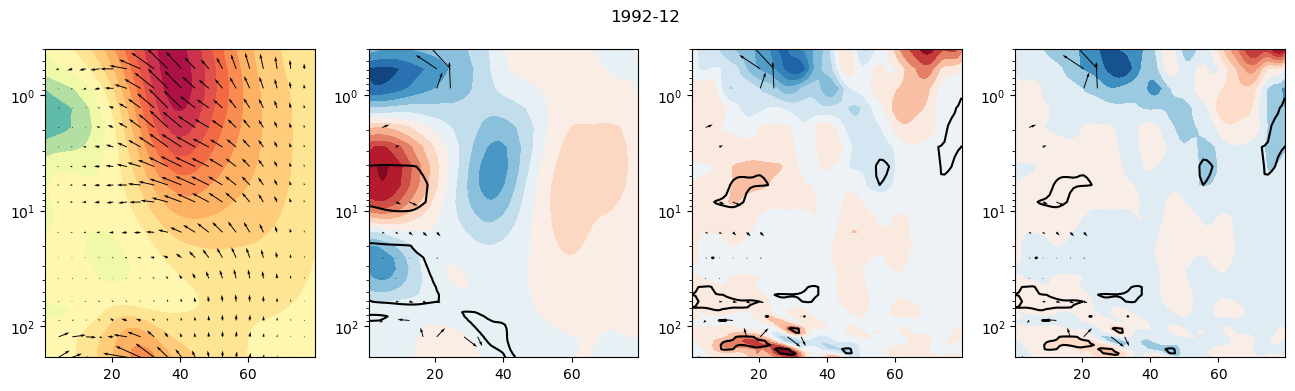

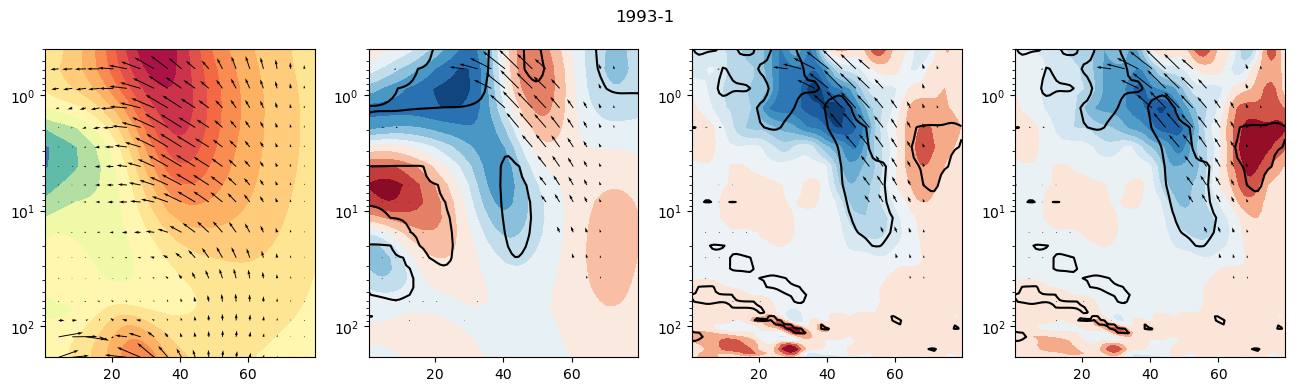

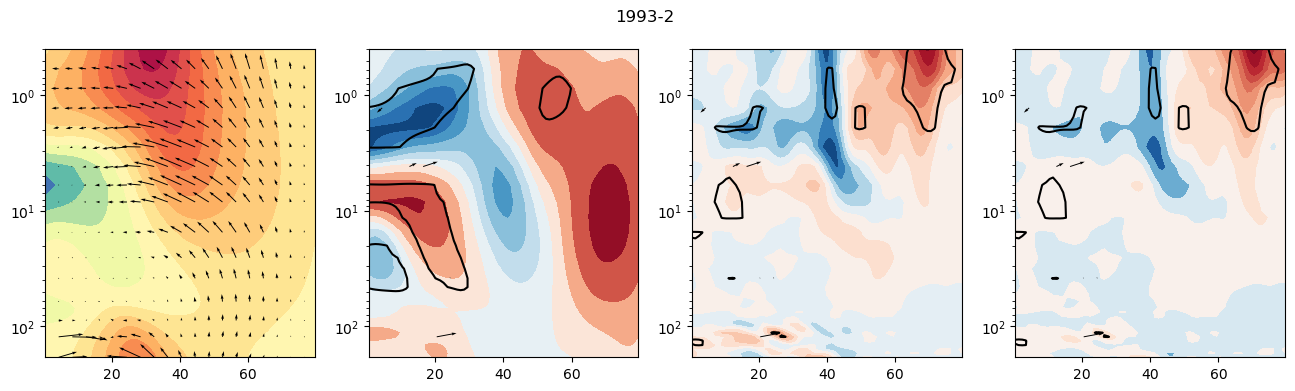

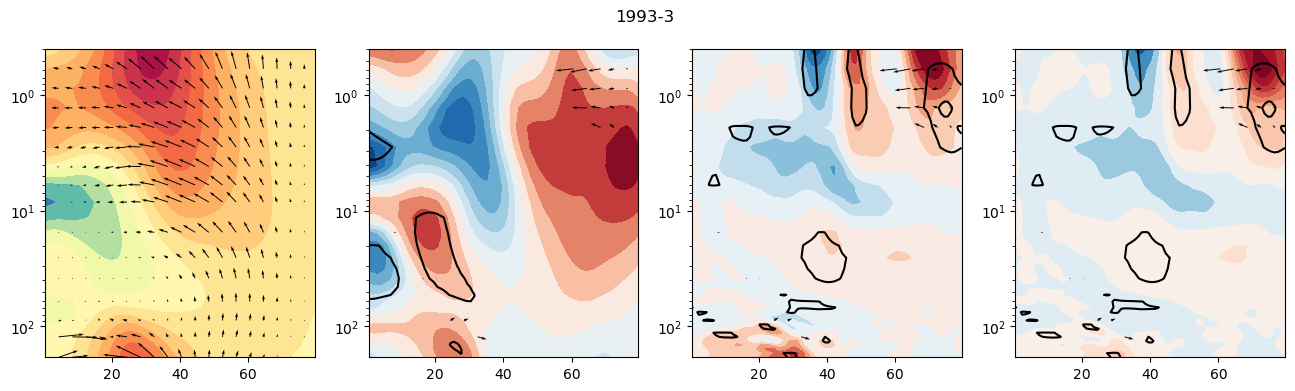

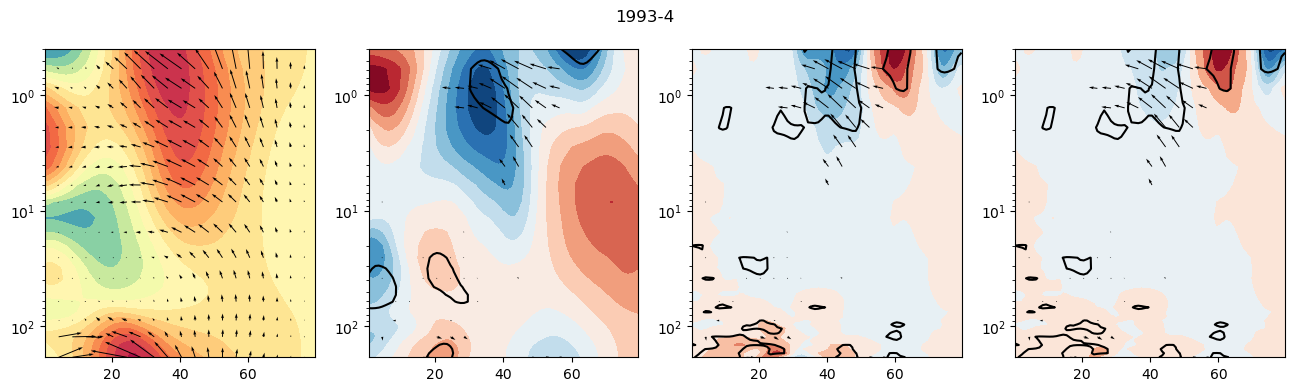

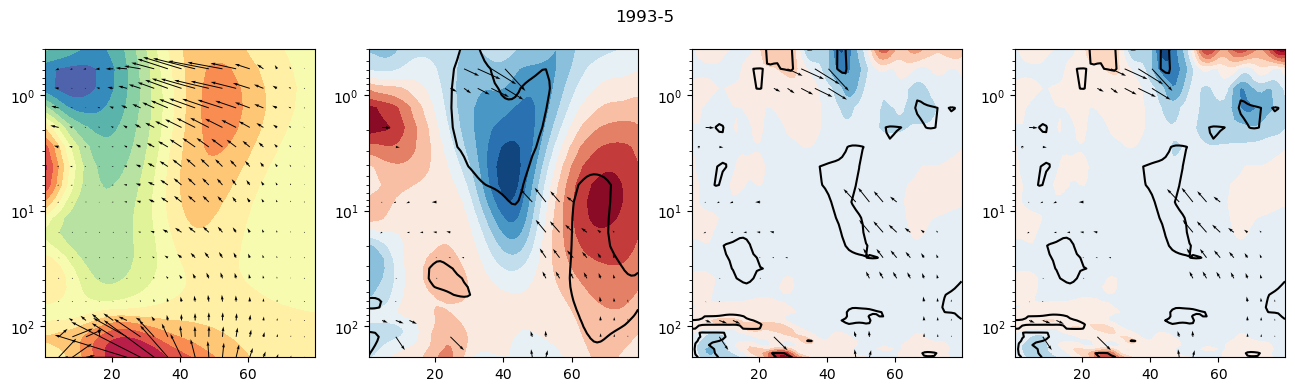

In [16]:
overwrite = False

if(0):
    #AS
    #tmin = date(1991, 8, 1)
    #tmax = date(1991, 9, 30)
    # ON
    #tmin = date(1991, 10, 1)
    #tmax = date(1991, 11, 30)
    #DJF
    tmin = date(1991, 12, 1)
    tmax = date(1992, 2, 28)
    u     = putil.get_daily_variable('U', tmin=tmin, tmax=tmax, overwrite=overwrite)
    epdiv = putil.get_daily_variable('epdiv', tmin=tmin, tmax=tmax, overwrite=overwrite)
    epfy  = putil.get_daily_variable('epfy', tmin=tmin, tmax=tmax, overwrite=overwrite)
    epfz  = putil.get_daily_variable('epfz', tmin=tmin, tmax=tmax, overwrite=overwrite)

years  = [1991, 1992, 1993]
months = [np.arange(6, 13, 1), np.arange(1, 13, 1), np.arange(1, 6, 1)]
pairs  = [[[years[i], int(month)] for month in months[i]] for i in range(3)]
pairs = pairs[0]+pairs[1]+pairs[2]

for i in range(len(pairs)):
    month = pairs[i][1]
    year  = pairs[i][0]
    u     = putil.get_daily_variable('U', year=year, month=month, overwrite=overwrite)
    utendepfd = putil.get_daily_variable('utendepfd', year=year, month=month, overwrite=overwrite)
    epdiv = putil.get_daily_variable('epdiv', year=year, month=month, overwrite=overwrite)
    epfy  = putil.get_daily_variable('epfy', year=year, month=month, overwrite=overwrite)
    epfz  = putil.get_daily_variable('epfz', year=year, month=month, overwrite=overwrite)
    print('{}-{}...'.format(year, month), end='\r')



    # delete EP Flux vectors for which p-value is > 0.05
    mask = np.logical_or(epfy['pval']<0.05, epfz['pval']<0.05)
    epfy_impact = epfy['impact'].where(mask)
    epfz_impact = epfz['impact'].where(mask)

    # select stratosphere
    pmin, pmax     = 0.3, 200
    latmin, latmax = 0, 80
    args = {'pmin':pmin, 'pmax':pmax, 'latmin':latmin, 'latmax':latmax}
    epfy_impact = putil.do_slicing(epfy_impact, **args)
    epfz_impact = putil.do_slicing(epfz_impact, **args)
    epfy_cf     = putil.do_slicing(epfy['cfmean'], **args)
    epfz_cf     = putil.do_slicing(epfz['cfmean'], **args)
    u_cf        = putil.do_slicing(u['cfmean'], **args)
    u_impact    = putil.do_slicing(u['impact'], **args)
    u_pval      = putil.do_slicing(u['pval'], **args)
    epdiv_cf        = putil.do_slicing(epdiv['cfmean'], **args)
    epdiv_impact    = putil.do_slicing(epdiv['impact'], **args)
    epdiv_pval      = putil.do_slicing(epdiv['pval'], **args)
    utendepfd_cf        = putil.do_slicing(utendepfd['cfmean'], **args)
    utendepfd_impact    = putil.do_slicing(utendepfd['impact'], **args)
    utendepfd_pval      = putil.do_slicing(utendepfd['pval'], **args)


    lat = epfy_impact.lat
    plev = epfy_impact.plev

    fig = plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_yscale('log')
        ax.invert_yaxis()
        ax.set_ylim([max(plev), min(plev)])
        ax.set_xlim([min(lat), max(lat)])
    dslat = 4
    dsp = 1.5

    Fx_cf, Fy_cf = putil.scale_EP_flux_vectors(fig, ax1, epfy_cf, epfz_cf, dslat=dslat, dsp=dsp)
    Fx_impact, Fy_impact = putil.scale_EP_flux_vectors(fig, ax2, epfy_impact, epfz_impact, dslat=dslat, dsp=dsp, norm=False)

    cmap = 'Spectral_r'
    cmapi = 'RdBu_r'
    norm = TwoSlopeNorm(vcenter=0)
    ax1.contourf(lat, plev, u_cf.T, cmap=cmap, levels=12, norm=norm)
    norm = TwoSlopeNorm(vcenter=0)
    ax2.contourf(lat, plev, u_impact.T, cmap=cmapi, levels=12, norm=norm)
    ax2.contour(lat, plev, u_pval.T, colors='k', levels=[0.05])
    norm = TwoSlopeNorm(vcenter=0)
    ax3.contourf(lat, plev, epdiv_impact.T, cmap=cmapi, levels=12, norm=norm)
    ax3.contour(lat, plev, epdiv_pval.T, colors='k', levels=[0.05])
    norm = TwoSlopeNorm(vcenter=0)
    ax4.contourf(lat, plev, utendepfd_impact.T, cmap=cmapi, levels=12, norm=norm)
    ax4.contour(lat, plev, utendepfd_pval.T, colors='k', levels=[0.05])

    LAT, PLEV = np.meshgrid(Fx_cf.lat, Fx_cf.plev)
    ax1.quiver(LAT, PLEV, Fx_cf.T, Fy_cf.T)
    ax2.quiver(LAT, PLEV, Fx_impact.T, Fy_impact.T)
    ax3.quiver(LAT, PLEV, Fx_impact.T, Fy_impact.T)
    ax4.quiver(LAT, PLEV, Fx_impact.T, Fy_impact.T)
    
    fig.suptitle('{}-{}'.format(pairs[i][0], pairs[i][1]))

plt.show()